<a href="https://colab.research.google.com/github/Sjoerd-de-Witte/Machine-Learning-2023/blob/main/2_1_Hyperparameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown -O /tmp/ml.py 174lBNvDBJSVWs3OpNL3a68cnhWIcWYuY
%run /tmp/ml.py

Downloading...
From: https://drive.google.com/uc?id=174lBNvDBJSVWs3OpNL3a68cnhWIcWYuY
To: /tmp/ml.py
100% 1.31k/1.31k [00:00<00:00, 5.42MB/s]


# Tuning Hyperparameters

We will fit a Decision Tree for the Wine dataset, and tune the hyperparameter max_depth.

In [2]:
from pipetorch import DFrame
from pipetorch.evaluate.study import Study
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df = DFrame.read_from_kaggle('uciml/red-wine-quality-cortez-et-al-2009')
df.quality = df.quality > 5
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,False
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,False
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,False
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,True
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,False
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,True
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,True
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,False


# Apply cross validation

To diagnose and validate the model, you have to split the dataset in a training and validation part before training. You can do this with the `split()` method on a PipeTorch DataFrame. As a parameter, you can pass the fraction of the dataset (e.g. split(0.8) to use 20% for training and 80% for validation, but is that a desirable split?).

In this case, because we will fit a Decision Tree, scaling is not an issue, and Regularization is not available (Decision Trees cannot overfit by using absurd coefficients to connect the dots, like Polynomial Regression, SVM or Logistic Regression).

In [8]:
# split the dataset
df = df.split(valid_size=0.8)

# Model & Train

In [9]:
# Fit a Decision Tree on all features with a maximum tree depth of 20
# and fit the model on the dataset
model = DecisionTreeClassifier(max_depth=20)
model.fit(df.train_X, df.train_y)

DecisionTreeClassifier(max_depth=20)

# Evaluation

In [10]:
# Report the accuracy
accuracy_score(df.valid_y, model.predict(df.valid_X))

0.67421875

# Tune max_depth

Create a study and a trail function to find the optimal value for max_depth.

In [11]:
# Setup an evaluator on this DataFrame to compare accuracy scores across models
study = Study.create_study('accuracy_score')

[I 2023-09-26 11:42:37,036] A new study created in memory with name: no-name-af0024de-491f-4669-b25a-087f910d6354


In [16]:
# write a trial function, in which you sample a valie for max_depth, instantiate a decision tree with it
# fit the tree, and return the accuracy score over the validation set.

def trial(trial):
    # sample the hyperparameter(s) from the Optuna Study
    degree = trial.suggest_categorical('depth',list(range(10,150,5)))

    # For your experiment, prepare the data and fit the model using the hyperparameters
    model = DecisionTreeClassifier(max_depth=degree)
    model.fit(df.train_X, df.train_y)

    # Compute whatever you wish to analyze or optimize
    pred_y = model.predict(df.train_X)
    accuracy_train = accuracy_score(df.train_y, pred_y)
    pred_y = model.predict(df.valid_X)
    accuracy_valid = accuracy_score(df.valid_y, pred_y)

    # Return multiple values in the right order
    return accuracy_valid

In [17]:
# Run the optimizer
# In our solution, we have used a random search
# but it is also ok if you stick to the grid search that we used in the example.
# If you do use random search, be sure to include something like `n_trials=100` in the call to `optimize`.
study.optimize(trial, n_trials = 100)

[I 2023-09-26 12:01:23,788] Trial 903 finished with value: 0.66171875 and parameters: {'depth': 110}. Best is trial 645 with value: 0.70546875.
[I 2023-09-26 12:01:24,028] Trial 904 finished with value: 0.68125 and parameters: {'depth': 35}. Best is trial 645 with value: 0.70546875.
[I 2023-09-26 12:01:24,280] Trial 905 finished with value: 0.68828125 and parameters: {'depth': 80}. Best is trial 645 with value: 0.70546875.
[I 2023-09-26 12:01:24,519] Trial 906 finished with value: 0.69140625 and parameters: {'depth': 55}. Best is trial 645 with value: 0.70546875.
[I 2023-09-26 12:01:24,763] Trial 907 finished with value: 0.6765625 and parameters: {'depth': 50}. Best is trial 645 with value: 0.70546875.
[I 2023-09-26 12:01:24,996] Trial 908 finished with value: 0.67734375 and parameters: {'depth': 20}. Best is trial 645 with value: 0.70546875.
[I 2023-09-26 12:01:25,231] Trial 909 finished with value: 0.66171875 and parameters: {'depth': 40}. Best is trial 645 with value: 0.70546875.
[I

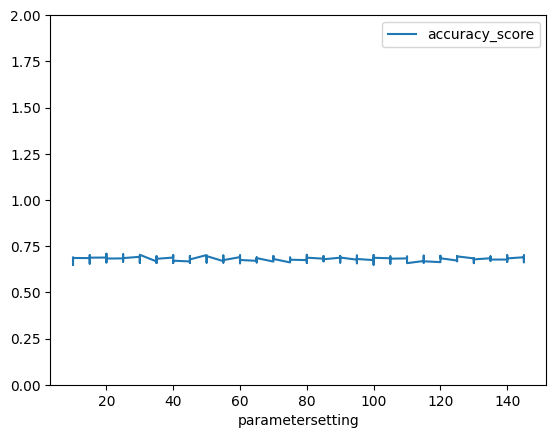

In [18]:
# plot the results
study.plot_targets()
plt.ylim(0,2);

In [ ]:
halt_notebook()